# Calibrating the concept learning layer of concept bottleneck models

This is based heavily on [Koh et al 2020](https://arxiv.org/pdf/2007.04612) and I'm only implementing independent and sequential models because it's 6am and I wanna sleep.

Actually, sequential only, because independent doesn't benefit from calibration expect through accuracy (it takes binary concept membership inputs because that's what it's trained on).

In [1]:
import os
from itertools import product
import numpy as np
import pandas as pd
import pickle
from scipy.special import logit, expit
import torch
import torch.nn as nn
from IPython.display import display

from sklearn.linear_model import LogisticRegression

from utils.concept_bottleneck_models import CosineSimilarityModel, MLPConceptModel, RandomForestConceptModel
from utils.concept_bottleneck_metrics import *
from utils.concept_bottleneck_calibration import CalibratedConceptModel
from utils.concept_bottleneck_visualization import *

from matplotlib import pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
dataset_name = 'CUB'

In [3]:
# (option 1) specify which calibration strategies to run
calibration_methods = ['Platt L2', 'Platt L1', 'Platt'] # ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']
calibration_levels  = ['global', 'individual']

# encode as boolean and format together
calibration_levels  = zip(calibration_levels, [lvl == 'individual' for lvl in calibration_levels])
calibrator_params   = product(calibration_methods, calibration_levels) # can also specify these individually in a list of tuples
calibrator_params   = [(m, l, i) for m, (l, i) in calibrator_params]

# (option 2) specify individually as a list of tuples
# calibrator_params = [('Platt L2', 'individual', True), ('Isotonic', 'global', False)]

# display
for m, l, i in calibrator_params:
    print(m, l, i)

Platt L2 global False
Platt L2 individual True
Platt L1 global False
Platt L1 individual True
Platt global False
Platt individual True


## 1. Get pre-processed data

In [4]:
metadata_df = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')
cosine_similarity_df = pd.read_csv(f'Cosine_Similarities/{dataset_name}/cosine_similarities.csv')

/tmp/ipykernel_1337268/2056268533.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')


In [5]:
if dataset_name == 'CLEVR':
    metadata_df = metadata_df.drop(['size::large','material::rubber'], axis=1)
    cosine_similarity_df = cosine_similarity_df.drop(['size::large','material::rubber'], axis=1)

In [6]:
concepts = list(cosine_similarity_df.columns)
classes = metadata_df['class'].unique()
classes.sort()

train_mask = metadata_df['split'] == 'train'
train_embeddings = embeddings[train_mask]
train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
train_cosine_similarity_df = cosine_similarity_df[train_mask].reset_index(drop=True)
train_concepts = torch.from_numpy(train_metadata_df[concepts].to_numpy()) # each row is a k-dimensional y-value
train_labels = train_metadata_df["class"]

cal_mask = metadata_df['split'] == 'calibration'
cal_embeddings = embeddings[cal_mask]
cal_metadata_df = metadata_df[cal_mask].reset_index(drop=True)
cal_cosine_similarity_df = cosine_similarity_df[cal_mask].reset_index(drop=True)
cal_concepts = torch.from_numpy(cal_metadata_df[concepts].to_numpy())
cal_labels = cal_metadata_df["class"]

test_mask = metadata_df['split'] == 'test'
test_embeddings = embeddings[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)
test_concepts = torch.from_numpy(test_metadata_df[concepts].to_numpy())
test_labels = test_metadata_df["class"]

In [7]:
train_labels_onehot = pd.get_dummies(train_labels)
cal_labels_onehot = pd.get_dummies(cal_labels)
test_labels_onehot = pd.get_dummies(test_labels)

assert((train_labels_onehot.columns == classes).all())
assert((cal_labels_onehot.columns == classes).all())
assert((test_labels_onehot.columns == classes).all())

train_labels_onehot = train_labels_onehot.to_numpy(dtype=int)
cal_labels_onehot = cal_labels_onehot.to_numpy(dtype=int)
test_labels_onehot = test_labels_onehot.to_numpy(dtype=int)

## 2. Concept Model Utils

Moved to `utils`.

## 3. Train concept models
Cosine similarity based models that take in foundation model-derived embeddings.

$M_1$ : Logistic regression from concept similarity score to concept presence probability, for each concept (2 parameters trained on labelled concepts)

$M_2$ : MLP from embedding to concept presence probability, for each concept (neural net trained on labelled concepts)

$M_3$ : Random forest classifier from embedding to concept presence probabilities, handles all concepts at once

Maybe eventually, base models from the previous paper

$M_2$ is horrifically slow so we're skipping it for now.

### a) Base sequential models
#### $M_1$

In [8]:
if False:
    M1 = CosineSimilarityModel(concepts=concepts, seed = 42)
    M1.fit(train_cosine_similarity_df, train_concepts, verbose = False)
    
    # save
    with open('Models/CBM/M1/concepts-base-2.pkl','wb') as f: # FIXME why the 2?
        pickle.dump(M1, f)
else:
    # load
    with open('Models/CBM/M1/concepts-base-2.pkl', 'rb') as f:
        M1 = pickle.load(f)

In [9]:
M1_test_concepts_pred = M1.predict(test_cosine_similarity_df)
M1_acc, _, _ = concept_accuracies(M1_test_concepts_pred, test_concepts.numpy(), 
                                  concepts=concepts, verbose = True, ste_coef = 2)

0. has_back_color::black Test Accuracy: 78.05 ± 1.73%
1. has_back_color::blue Test Accuracy: 96.55 ± 0.76%
2. has_back_color::brown Test Accuracy: 79.93 ± 1.67%
3. has_back_color::buff Test Accuracy: 85.03 ± 1.49%
4. has_back_color::green Test Accuracy: 98.47 ± 0.51%
5. has_back_color::grey Test Accuracy: 76.66 ± 1.77%
6. has_back_color::iridescent Test Accuracy: 98.34 ± 0.53%
7. has_back_color::olive Test Accuracy: 96.64 ± 0.75%
8. has_back_color::orange Test Accuracy: 98.73 ± 0.47%
9. has_back_color::pink Test Accuracy: 99.61 ± 0.26%
10. has_back_color::purple Test Accuracy: 99.65 ± 0.25%
11. has_back_color::red Test Accuracy: 98.65 ± 0.48%
12. has_back_color::rufous Test Accuracy: 99.21 ± 0.37%
13. has_back_color::white Test Accuracy: 84.60 ± 1.51%
14. has_back_color::yellow Test Accuracy: 93.15 ± 1.06%
15. has_back_pattern::multi-colored Test Accuracy: 80.32 ± 1.66%
16. has_back_pattern::solid Test Accuracy: 64.79 ± 2.00%
17. has_back_pattern::spotted Test Accuracy: 93.11 ± 1.06%
1

In [10]:
cal_error_k1, k1_errors = concept_calibration_errors(M1_test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                     verbose = False, measure = 'K1', bins=10)
cal_error_k2, k2_errors = concept_calibration_errors(M1_test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                     verbose = False, measure = 'K2', bins=10)
cal_error_kmax, kmax_errors = concept_calibration_errors(M1_test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                         verbose = False, measure = 'Kmax', bins=10)
print(f'Pooled calibration error\nK1   : {cal_error_k1:.4f}\nK2   : {cal_error_k2:.4f}\nKmax : {cal_error_kmax:.4f}')

Pooled calibration error
K1   : 0.0153
K2   : 0.0051
Kmax : 0.0153


In [11]:
M1_cal_errors = pd.DataFrame.from_dict({'K1' : pd.Series(k1_errors), 'K2' : pd.Series(k2_errors), 'Kmax' : pd.Series(kmax_errors)})
M1_cal_errors.sort_values(by='K1', ascending=False).head(10)

,K1,K2,Kmax
has_size::small_(5_-_9_in),0.254799,0.096877,0.254799
has_breast_pattern::solid,0.218586,0.072621,0.218586
has_belly_pattern::solid,0.211606,0.066685,0.211606
has_eye_color::black,0.166667,0.027778,0.166667
has_shape::perching-like,0.156632,0.046665,0.156632
has_bill_length::shorter_than_head,0.144415,0.034464,0.144415
has_bill_color::black,0.141361,0.047218,0.141361
has_underparts_color::white,0.120855,0.042646,0.120855
has_belly_color::white,0.113438,0.041193,0.113438
has_back_pattern::solid,0.104276,0.047290,0.104276


array([[<Axes: title={'center': 'K1'}>, <Axes: title={'center': 'K2'}>],
       [<Axes: title={'center': 'Kmax'}>, <Axes: >]], dtype=object)

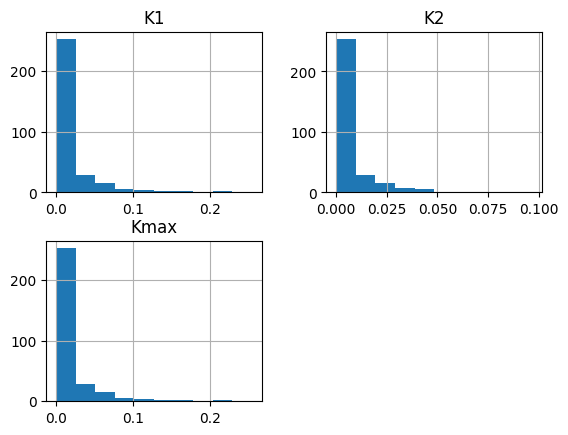

In [12]:
M1_cal_errors.hist()

#### $M_2$

In [13]:
if False:
    M2 = MLPConceptModel(concepts, seed = 42)
    M2.fit(train_embeddings, train_concepts, verbose = True)

In [14]:
if False:
    M2_test_concepts_pred = M2.predict(test_embeddings)
    M2_acc, _, _ = concept_accuracies(M2_test_concepts_pred, test_concepts.numpy(), 
                                      concepts=concepts, verbose = True)

#### $M_3$

In [15]:
if False:
    M3 = RandomForestConceptModel(concepts, seed = 42)
    M3.fit(train_embeddings, train_concepts, verbose = True)
    
    # save
    with open('Models/CBM/M3/concepts-base.pkl','wb') as f:
        pickle.dump(M3, f)
else:
    # load
    with open('Models/CBM/M3/concepts-base.pkl', 'rb') as f:
        M3 = pickle.load(f)

In [16]:
M3_test_concepts_pred = M3.model.predict(test_embeddings)
M3_acc, _, _ = concept_accuracies(M3_test_concepts_pred, test_concepts.numpy(), 
                                  concepts=concepts, verbose = True, ste_coef = 2)

0. has_back_color::black Test Accuracy: 71.90 ± 1.88%
1. has_back_color::blue Test Accuracy: 95.86 ± 0.83%
2. has_back_color::brown Test Accuracy: 80.89 ± 1.64%
3. has_back_color::buff Test Accuracy: 86.04 ± 1.45%
4. has_back_color::green Test Accuracy: 98.47 ± 0.51%
5. has_back_color::grey Test Accuracy: 74.52 ± 1.82%
6. has_back_color::iridescent Test Accuracy: 98.34 ± 0.53%
7. has_back_color::olive Test Accuracy: 96.64 ± 0.75%
8. has_back_color::orange Test Accuracy: 98.73 ± 0.47%
9. has_back_color::pink Test Accuracy: 99.61 ± 0.26%
10. has_back_color::purple Test Accuracy: 99.65 ± 0.25%
11. has_back_color::red Test Accuracy: 98.69 ± 0.47%
12. has_back_color::rufous Test Accuracy: 99.21 ± 0.37%
13. has_back_color::white Test Accuracy: 84.60 ± 1.51%
14. has_back_color::yellow Test Accuracy: 93.02 ± 1.06%
15. has_back_pattern::multi-colored Test Accuracy: 80.32 ± 1.66%
16. has_back_pattern::solid Test Accuracy: 62.65 ± 2.02%
17. has_back_pattern::spotted Test Accuracy: 93.11 ± 1.06%
1

In [17]:
cal_error_k1, k1_errors = concept_calibration_errors(M3_test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                     verbose = False, measure = 'K1', bins=10)
cal_error_k2, k2_errors = concept_calibration_errors(M3_test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                     verbose = False, measure = 'K2', bins=10)
cal_error_kmax, kmax_errors = concept_calibration_errors(M3_test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                         verbose = False, measure = 'Kmax', bins=10)
print(f'Pooled calibration error\nK1   : {cal_error_k1:.4f}\nK2   : {cal_error_k2:.4f}\nKmax : {cal_error_kmax:.4f}')

Pooled calibration error
K1   : 0.0056
K2   : 0.0018
Kmax : 0.0056


In [18]:
M3_cal_errors = pd.DataFrame.from_dict({'K1' : pd.Series(k1_errors), 'K2' : pd.Series(k2_errors), 'Kmax' : pd.Series(kmax_errors)})
M3_cal_errors.sort_values(by='K1', ascending=False).head(10)

,K1,K2,Kmax
has_belly_pattern::solid,0.440227,0.194991,0.440227
has_breast_pattern::solid,0.336387,0.135081,0.336387
has_size::small_(5_-_9_in),0.280977,0.109534,0.280977
has_bill_length::shorter_than_head,0.236038,0.076282,0.236038
has_eye_color::black,0.166667,0.027778,0.166667
has_shape::perching-like,0.165794,0.050121,0.165794
has_bill_length::about_the_same_as_head,0.030977,0.009319,0.030977
has_bill_shape::all-purpose,0.017888,0.004584,0.017888
has_underparts_color::white,0.014398,0.002862,0.014398
has_bill_color::black,0.013525,0.002833,0.013525


array([[<Axes: title={'center': 'K1'}>, <Axes: title={'center': 'K2'}>],
       [<Axes: title={'center': 'Kmax'}>, <Axes: >]], dtype=object)

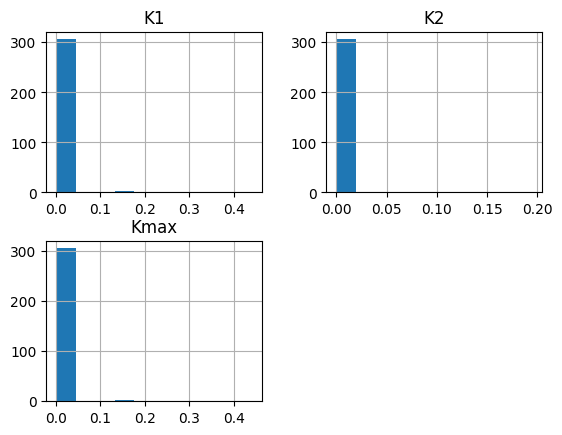

In [19]:
M3_cal_errors.hist()

In [20]:
base_concept_models = {
    '(M1) Cosine Similarity LogReg': M1,
    #'(M2) Embeddings MLP': M2,
    '(M3) Embeddings Random Forest': M3
}

### b) Calibrate models

In [21]:
# M1_concepts_cal['Platt L2 global'].calibrated_model #.estimator.estimator._is_fitted
# X = cal_cosine_similarity_df
# if type(X) is pd.core.frame.DataFrame:
#     print("hi")
#     X = X.to_numpy()
# print(X.shape)

In [22]:
M1.classes_ = concepts
M1._estimator_type = "classifier"

from sklearn.base import is_classifier
is_classifier(M1)

M1.__sklearn_tags__()

Tags(estimator_type='classifier', target_tags=TargetTags(required=True, one_d_labels=False, two_d_labels=True, positive_only=False, multi_output=True, single_output=False), transformer_tags=None, classifier_tags=ClassifierTags(poor_score=False, multi_class=False, multi_label=True), regressor_tags=None, array_api_support=False, no_validation=False, non_deterministic=False, requires_fit=True, _skip_test=False, input_tags=InputTags(one_d_array=False, two_d_array=True, three_d_array=False, sparse=False, categorical=False, string=False, dict=False, positive_only=False, allow_nan=False, pairwise=False))

#### $M_1$

In [23]:
M1_concepts_cal = {}

# FIXME pickle cache for these
for method, version, i in calibrator_params:
# for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']: #, 'Platt L2'
#     for i, version in enumerate(['global', 'individual']):
    name = '{} {}'.format(method, version)
    print(name)
    M1_concepts_cal[name] = CalibratedConceptModel(M1, method = method, individual = i)
    M1_concepts_cal[name].calibrate(cal_cosine_similarity_df, cal_concepts.numpy())

Platt L2 global
Platt L2 individual
Platt L1 global
Platt L1 individual


/home/eshedden/fa24/Calibrated_Concepts/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Platt global
Platt individual


Pooled calibration error
K1   : 0.01656402
K2   : 0.00563747
Kmax : 0.01656402


,K1,K2,Kmax
has_size::small_(5_-_9_in),0.260035,0.098903,0.260035
has_breast_pattern::solid,0.226440,0.076165,0.226440
has_belly_pattern::solid,0.219895,0.070501,0.219895
has_eye_color::black,0.166667,0.027778,0.166667
has_shape::perching-like,0.162740,0.049151,0.162740
has_bill_color::black,0.150087,0.051322,0.150087
has_bill_length::shorter_than_head,0.150087,0.036669,0.150087
has_underparts_color::white,0.127400,0.045645,0.127400
has_belly_color::white,0.119983,0.044111,0.119983
has_back_pattern::solid,0.114747,0.052760,0.114747


array([[<Axes: title={'center': 'K1'}>, <Axes: title={'center': 'K2'}>],
       [<Axes: title={'center': 'Kmax'}>, <Axes: >]], dtype=object)

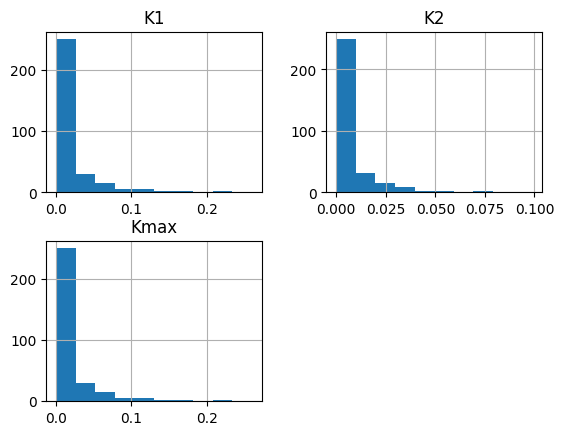

Pooled calibration error
K1   : 0.01615849
K2   : 0.00544713
Kmax : 0.01615849


,K1,K2,Kmax
has_size::small_(5_-_9_in),0.258290,0.097955,0.258290
has_breast_pattern::solid,0.217714,0.072282,0.217714
has_belly_pattern::solid,0.216405,0.068983,0.216405
has_eye_color::black,0.166667,0.027778,0.166667
has_shape::perching-like,0.165794,0.050241,0.165794
has_bill_length::shorter_than_head,0.136998,0.031936,0.136998
has_bill_color::black,0.121728,0.038637,0.121728
has_underparts_color::white,0.120855,0.042646,0.120855
has_belly_color::white,0.115183,0.041655,0.115183
has_wing_color::black,0.115183,0.037311,0.115183


array([[<Axes: title={'center': 'K1'}>, <Axes: title={'center': 'K2'}>],
       [<Axes: title={'center': 'Kmax'}>, <Axes: >]], dtype=object)

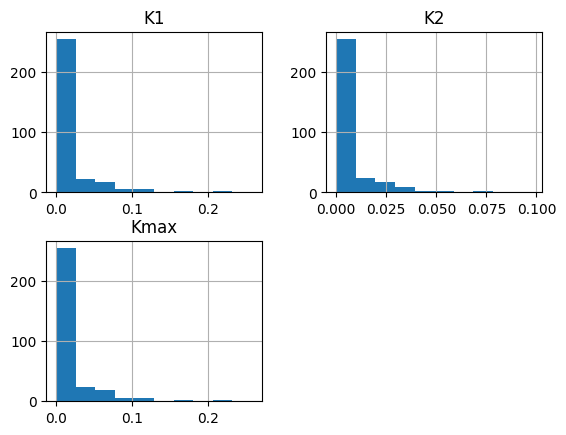

In [24]:
methods_to_evaluate = ['Platt global', 'Platt individual']

for name in methods_to_evaluate:
    test_concepts_pred = M1_concepts_cal[name].predict(test_cosine_similarity_df)
    
    cal_error_k1, k1_errors = concept_calibration_errors(test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                         verbose = False, measure = 'K1', bins=10)
    cal_error_k2, k2_errors = concept_calibration_errors(test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                         verbose = False, measure = 'K2', bins=10)
    cal_error_kmax, kmax_errors = concept_calibration_errors(test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                             verbose = False, measure = 'Kmax', bins=10)
    print(f'Pooled calibration error\nK1   : {cal_error_k1:.8f}\nK2   : {cal_error_k2:.8f}\nKmax : {cal_error_kmax:.8f}')

    cal_errors = pd.DataFrame.from_dict({'K1' : pd.Series(k1_errors), 'K2' : pd.Series(k2_errors), 'Kmax' : pd.Series(kmax_errors)})
    display(cal_errors.sort_values(by='K1', ascending=False).head(10))
    display(cal_errors.hist())
    plt.show()

#### $M_3$

In [25]:
M3_concepts_cal = {}

for method, version, i in calibrator_params:
# for method in ['Histogram', 'Isotonic', 'Platt', 'Temperature', 'Beta']: #, 'Platt L2'
#     for i, version in enumerate(['global', 'individual']):
    name = '{} {}'.format(method, version)
    print(name)
    M3_concepts_cal[name] = CalibratedConceptModel(M3, method = method, individual = i)
    M3_concepts_cal[name].calibrate(cal_embeddings, cal_concepts.numpy())

Platt L2 global
Platt L2 individual
Platt L1 global
Platt L1 individual


/home/eshedden/fa24/Calibrated_Concepts/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eshedden/fa24/Calibrated_Concepts/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eshedden/fa24/Calibrated_Concepts/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eshedden/fa24/Calibrated_Concepts/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/eshedden/fa24/Calibrated_Concepts/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

Platt global
Platt individual


Pooled calibration error
K1   : 0.00835263
K2   : 0.00290245
Kmax : 0.00835263


,K1,K2,Kmax
has_belly_pattern::solid,0.445026,0.198048,0.445026
has_breast_pattern::solid,0.409250,0.175366,0.409250
has_size::small_(5_-_9_in),0.326789,0.133532,0.326789
has_bill_length::shorter_than_head,0.299738,0.109649,0.299738
has_bill_color::black,0.269197,0.118301,0.269197
has_shape::perching-like,0.246946,0.088295,0.246946
has_eye_color::black,0.166667,0.027778,0.166667
has_wing_color::black,0.075480,0.022436,0.075480
has_bill_length::about_the_same_as_head,0.068935,0.024867,0.068935
has_bill_shape::all-purpose,0.062827,0.019498,0.062827


array([[<Axes: title={'center': 'K1'}>, <Axes: title={'center': 'K2'}>],
       [<Axes: title={'center': 'Kmax'}>, <Axes: >]], dtype=object)

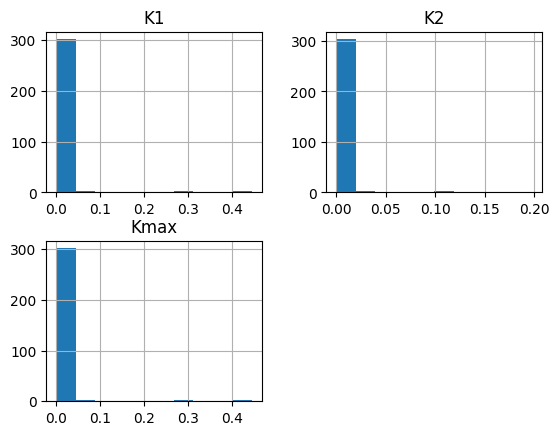

Pooled calibration error
K1   : 0.01331834
K2   : 0.00463509
Kmax : 0.01331834


,K1,K2,Kmax
has_belly_pattern::solid,0.276614,0.104265,0.276614
has_size::small_(5_-_9_in),0.273124,0.106262,0.273124
has_breast_pattern::solid,0.272251,0.101667,0.272251
has_shape::perching-like,0.172775,0.052833,0.172775
has_bill_length::shorter_than_head,0.169284,0.046093,0.169284
has_eye_color::black,0.166667,0.027778,0.166667
has_bill_color::black,0.123909,0.044885,0.123909
has_wing_color::black,0.116056,0.040943,0.116056
has_bill_length::about_the_same_as_head,0.099476,0.037864,0.099476
has_bill_shape::all-purpose,0.098168,0.033619,0.098168


array([[<Axes: title={'center': 'K1'}>, <Axes: title={'center': 'K2'}>],
       [<Axes: title={'center': 'Kmax'}>, <Axes: >]], dtype=object)

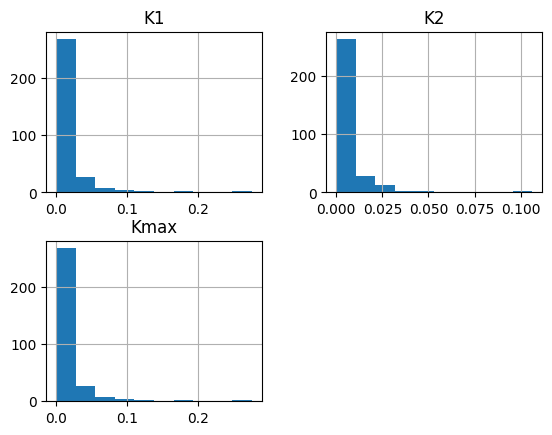

In [26]:
methods_to_evaluate = ['Platt L1 global', 'Platt L1 individual']

for name in methods_to_evaluate:
    test_concepts_pred = M3_concepts_cal[name].predict(test_embeddings)
    
    cal_error_k1, k1_errors = concept_calibration_errors(test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                         verbose = False, measure = 'K1', bins=10)
    cal_error_k2, k2_errors = concept_calibration_errors(test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                         verbose = False, measure = 'K2', bins=10)
    cal_error_kmax, kmax_errors = concept_calibration_errors(test_concepts_pred, test_concepts.numpy(), concepts = concepts, 
                                                             verbose = False, measure = 'Kmax', bins=10)
    print(f'Pooled calibration error\nK1   : {cal_error_k1:.8f}\nK2   : {cal_error_k2:.8f}\nKmax : {cal_error_kmax:.8f}')

    cal_errors = pd.DataFrame.from_dict({'K1' : pd.Series(k1_errors), 'K2' : pd.Series(k2_errors), 'Kmax' : pd.Series(kmax_errors)})
    display(cal_errors.sort_values(by='K1', ascending=False).head(10))
    display(cal_errors.hist())
    plt.show()

In [27]:
calibrated_models = {'(M1) Cosine Similarity LogReg': M1_concepts_cal,
                     #'(M2) Embeddings MLP': M2_models_cal,
                     '(M3) Embeddings Random Forest': M3_concepts_cal
                    }

## 5. Train sequential target models

Per the paper I'm basing all of this off of, this is basically just training a logistic activation layer

### a) Base concept models

In [28]:
if False:
    M1_seq = LogisticRegression(random_state=42, max_iter=1000)
    M1_seq.fit(M1.decision_function(train_cosine_similarity_df), train_labels)
    
    # save
    with open('Models/CBM/M1/seq-base.pkl','wb') as f:
        pickle.dump(M1_seq, f)
else:
    # load
    with open('Models/CBM/M1/seq-base.pkl', 'rb') as f:
        M1_seq = pickle.load(f)

In [29]:
if False:
    M3_seq = LogisticRegression(random_state=42, max_iter=1000)
    M3_seq.fit(M3.decision_function(train_embeddings), train_labels)
    
    # save
    with open('Models/CBM/M3/seq-base.pkl','wb') as f:
        pickle.dump(M3_seq, f)
else:
    # load
    with open('Models/CBM/M3/seq-base.pkl', 'rb') as f:
        M3_seq = pickle.load(f)

### b) Calibrated concept models

In [30]:
M1_seq_cal = {}

refit = {'Histogram global'      : False, 'Histogram individual'      : False, 
         'Isotonic global'       : False, 'Isotonic individual'       : False, 
         'Platt global'          : False, 'Platt individual'          : False, 
         'Platt L1 global'       : False, 'Platt L1 individual'       : False, 
         'Platt L2 global'       : False, 'Platt L2 individual'       : False, 
         'Temperature global'    : False, 'Temperature individual'    : False, 
         'Temperature L1 global' : True,  'Temperature L1 individual' : True, 
         'Temperature L2 global' : True,  'Temperature L2 individual' : True, 
         'Beta global'           : False, 'Beta individual'           : False}
verbose = 0

for method, version, i in calibrator_params:
    name = '{} {}'.format(method, version)
    fname = 'Models/CBM/M1/seq-cal-{}-{}.pkl'.format(method, version)
    if refit[name]:
        print(name)
        M1_seq_cal[name] = LogisticRegression(random_state=42, max_iter=1000, verbose=verbose)
        train_concepts_pred = M1_concepts_cal[name].decision_function(train_cosine_similarity_df)
        M1_seq_cal[name].fit(train_concepts_pred, train_labels) # slow AF -- BOOKMARK
        
        # save
        with open(fname, 'wb') as f:
            pickle.dump(M1_seq_cal[name], f)
    else:
        # load
        with open(fname, 'rb') as f:
            M1_seq_cal[name] = pickle.load(f)

In [31]:
M3_seq_cal = {}

refit = {'Histogram global'      : False, 'Histogram individual'      : False, 
         'Isotonic global'       : False, 'Isotonic individual'       : False, 
         'Platt global'          : False, 'Platt individual'          : False, 
         'Platt L2 global'       : False, 'Platt L2 individual'       : False, 
         'Platt L1 global'       : False, 'Platt L1 individual'       : False, 
         'Temperature global'    : False, 'Temperature individual'    : False, 
         'Beta global'           : False, 'Beta individual'           : False}

for method, version, i in calibrator_params:
    name = '{} {}'.format(method, version)
    fname = 'Models/CBM/M3/seq-cal-{}-{}.pkl'.format(method, version)
    if refit[name]:
        print(name)
        M3_seq_cal[name] = LogisticRegression(random_state=42, max_iter=1000, verbose=verbose)
        train_concepts_pred = M3_concepts_cal[name].decision_function(train_embeddings)
        M3_seq_cal[name].fit(train_concepts_pred, train_labels)
        
        # save
        with open(fname, 'wb') as f:
            pickle.dump(M3_seq_cal[name], f)
    else:
        # load
        with open(fname, 'rb') as f:
            M3_seq_cal[name] = pickle.load(f)

## 6. Evaluate
### M1
#### Base model main task accuracy by dataset

In [32]:
# M1
train_cal_test_accuracy(M1, M1_seq, 
                        train_cosine_similarity_df, train_labels, 
                        cal_cosine_similarity_df, cal_labels, 
                        test_cosine_similarity_df, test_labels)

Train accuracy        : 95.14 ± 0.51%
Calibration accuracy  : 83.21 ± 1.55%
Test accuracy         : 83.03 ± 1.57%


In [33]:
# M3
train_cal_test_accuracy(M3, M3_seq, 
                        train_embeddings, train_labels, 
                        cal_embeddings, cal_labels, 
                        test_embeddings, test_labels)

Train accuracy        : 71.53 ± 1.07%
Calibration accuracy  : 56.68 ± 2.05%
Test accuracy         : 56.20 ± 2.07%


#### Make tables

In [34]:
M1_concepts_cal['Base'] = M1
M1_seq_cal['Base'] = M1_seq

M1_metrics = {}

In [35]:
M3_concepts_cal['Base'] = M3
M3_seq_cal['Base'] = M3_seq

M3_metrics = {}

#### Main task test accuracy by calibrator

In [36]:
# M1
main_task_test_accuracy(M1_concepts_cal, M1_seq_cal, test_cosine_similarity_df, test_labels, M1_metrics)

Calibration method          Accuracy (%)
Platt L2 global             82.98 ± 1.57
Platt L2 individual         82.85 ± 1.57
Platt L1 global             82.94 ± 1.57
Platt L1 individual         82.90 ± 1.57
Platt global                83.03 ± 1.57
Platt individual            82.46 ± 1.59
Base                        83.03 ± 1.57


In [37]:
# M3
main_task_test_accuracy(M3_concepts_cal, M3_seq_cal, test_embeddings, test_labels, M3_metrics)

Calibration method          Accuracy (%)
Platt L2 global             57.68 ± 2.06
Platt L2 individual         60.82 ± 2.04
Platt L1 global             58.03 ± 2.06
Platt L1 individual         60.34 ± 2.04
Platt global                57.85 ± 2.06
Platt individual            62.17 ± 2.03
Base                        56.20 ± 2.07


#### Concept test accuracy by calibrator

In [42]:
concept_test_accuracy(M1_concepts_cal, test_cosine_similarity_df, test_concepts, concepts, M1_metrics) # they're actually different in the next decimal tho

Calibration method          Concept accuracy (%)
Platt L2 global             91.55 ± 0.07
Platt L2 individual         91.55 ± 0.07
Platt L1 global             91.55 ± 0.07
Platt L1 individual         91.56 ± 0.07
Platt global                91.55 ± 0.07
Platt individual            91.55 ± 0.07
Base                        91.55 ± 0.07


In [43]:
concept_test_accuracy(M3_concepts_cal, test_embeddings, test_concepts, concepts, M3_metrics)

Calibration method          Concept accuracy (%)
Platt L2 global             90.73 ± 0.07
Platt L2 individual         91.15 ± 0.07
Platt L1 global             90.73 ± 0.07
Platt L1 individual         91.16 ± 0.07
Platt global                90.73 ± 0.07
Platt individual            91.17 ± 0.07
Base                        90.62 ± 0.07


#### End task calibration error by calibrator

In [45]:
main_task_test_calibration_error(M1_concepts_cal, M1_seq_cal, test_cosine_similarity_df, test_labels_onehot, M1_metrics)

Calibration method          K1       K2       Kmax
Platt L2 global             0.000    0.000    0.000
Platt L2 individual         0.000    0.000    0.000
Platt L1 global             0.000    0.000    0.000
Platt L1 individual         0.000    0.000    0.000
Platt global                0.000    0.000    0.000
Platt individual            0.000    0.000    0.000
Base                        0.000    0.000    0.000


In [46]:
main_task_test_calibration_error(M3_concepts_cal, M3_seq_cal, test_embeddings, test_labels_onehot, M3_metrics)

Calibration method          K1       K2       Kmax
Platt L2 global             0.002    0.000    0.001
Platt L2 individual         0.001    0.000    0.000
Platt L1 global             0.002    0.000    0.001
Platt L1 individual         0.001    0.000    0.000
Platt global                0.002    0.000    0.001
Platt individual            0.000    0.000    0.000
Base                        0.002    0.000    0.001


#### Output table

In [48]:
M1_metrics_da = create_metrics_dataframe(M1_metrics)
M3_metrics_da = create_metrics_dataframe(M3_metrics)
metrics_da = pd.concat({'LCS' : M1_metrics_da, 'RF' : M3_metrics_da})
metrics_da

Main task accuracy (%) Concept accuracy (%)  \
LCS Platt L2 Global               82.98 ± 1.57         91.55 ± 0.07   
             Individual           82.85 ± 1.57         91.55 ± 0.07   
    Platt L1 Global               82.94 ± 1.57         91.55 ± 0.07   
             Individual           82.90 ± 1.57         91.56 ± 0.07   
    Platt    Global               83.03 ± 1.57         91.55 ± 0.07   
             Individual           82.46 ± 1.59         91.55 ± 0.07   
    None     -                    83.03 ± 1.57         91.55 ± 0.07   
RF  Platt L2 Global               57.68 ± 2.06         90.73 ± 0.07   
             Individual           60.82 ± 2.04         91.15 ± 0.07   
    Platt L1 Global               58.03 ± 2.06         90.73 ± 0.07   
             Individual           60.34 ± 2.04         91.16 ± 0.07   
    Platt    Global               57.85 ± 2.06         90.73 ± 0.07   
             Individual           62.17 ± 2.03         91.17 ± 0.07   
    None     -                    56.20 ± 2.07         90.62 ± 0.07   

                        Main task K1 Main task K2 Main task Kmax  
LCS Platt L2 Global            0.000        0.000          0.000  
             Individual        0.000        0.000          0.000  
    Platt L1 Global            0.000        0.000          0.000  
             Individual        0.000        0.000          0.000  
    Platt    Global            0.000        0.000          0.000  
             Individual        0.000        0.000          0.000  
    None     -                 0.000        0.000          0.000  
RF  Platt L2 Global            0.002        0.000          0.001  
             Individual        0.001        0.000          0.000  
    Platt L1 Global            0.002        0.000          0.001  
             Individual        0.001        0.000          0.000  
    Platt    Global            0.002        0.000          0.001  
             Individual        0.000        0.000          0.000  
    None     -                 0.002        0.000          0.001

In [49]:
with open(os.path.join('Results/CBMs/metrics.tex'), 'w') as tf:
     tf.write(metrics_da.to_latex())

#### Plot calibration functions

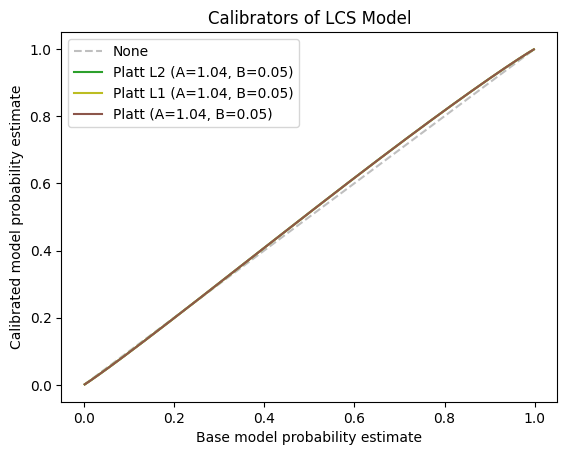

In [50]:
# M1
plot_calibrators(M1_concepts_cal, "LCS", path = "Results/CBMs/calibration_functions/seqCBM-LCS-global.png")

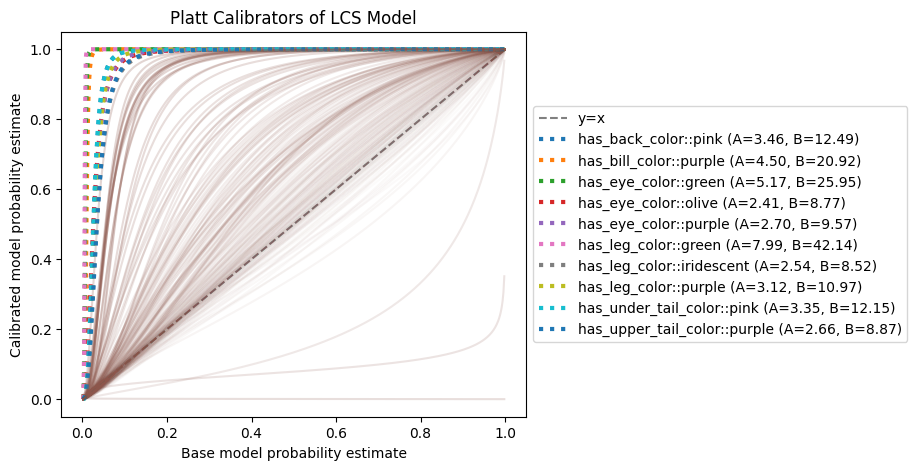

In [51]:
_ = plot_individual_calibrator(M1_concepts_cal['Platt individual'], 'LCS', 'Platt', 
                               path = "Results/CBMs/calibration_functions/seqCBM-LCS-Platt-individual.png")

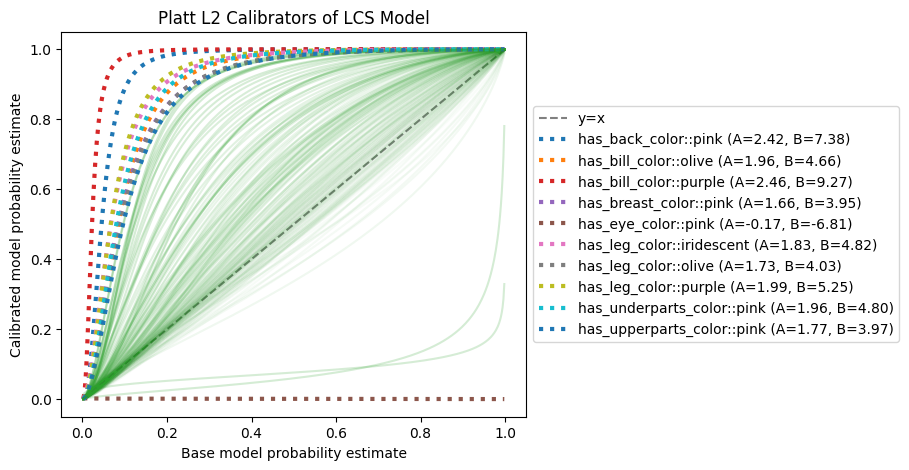

In [52]:
_ = plot_individual_calibrator(M1_concepts_cal['Platt L2 individual'], 'LCS', 'Platt L2', 
                               path = "Results/CBMs/calibration_functions/seqCBM-LCS-Platt-L2-individual.png")

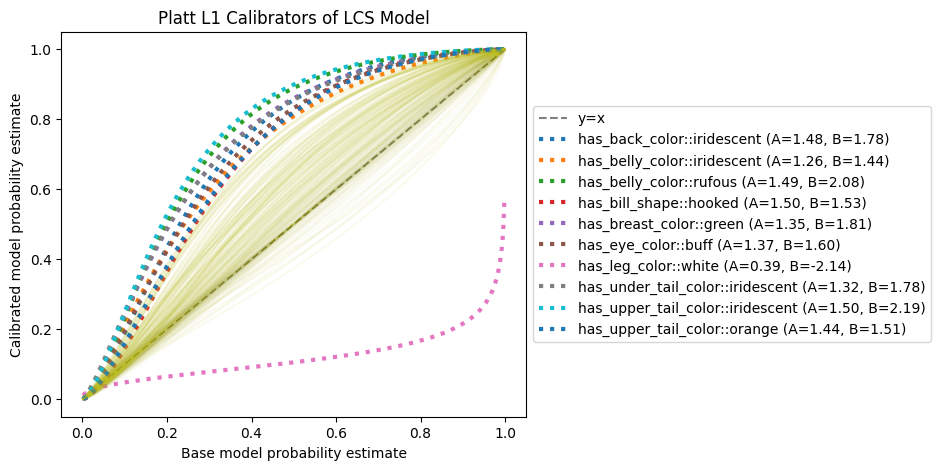

In [53]:
_ = plot_individual_calibrator(M1_concepts_cal['Platt L1 individual'], 'LCS', 'Platt L1', 
                               path = "Results/CBMs/calibration_functions/seqCBM-LCS-Platt-L1-individual.png")

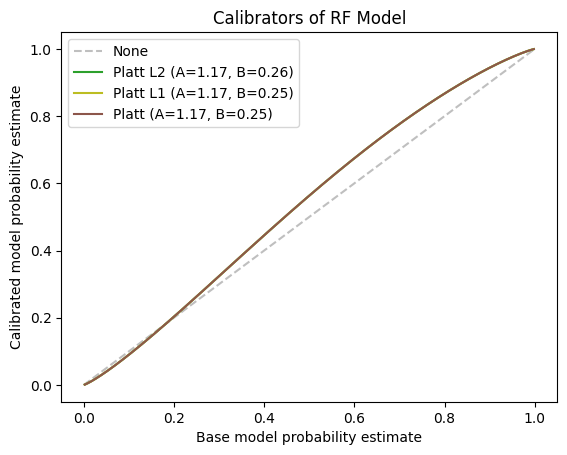

In [54]:
plot_calibrators(M3_concepts_cal, "RF", path = "Results/CBMs/calibration_functions/seqCBM-RF-global.png")

#### Plot calibration error curves

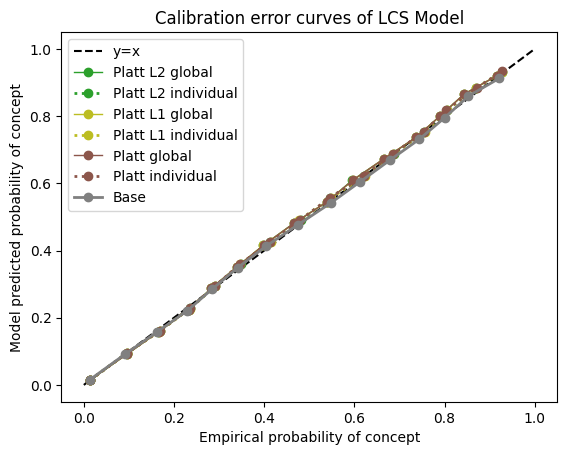

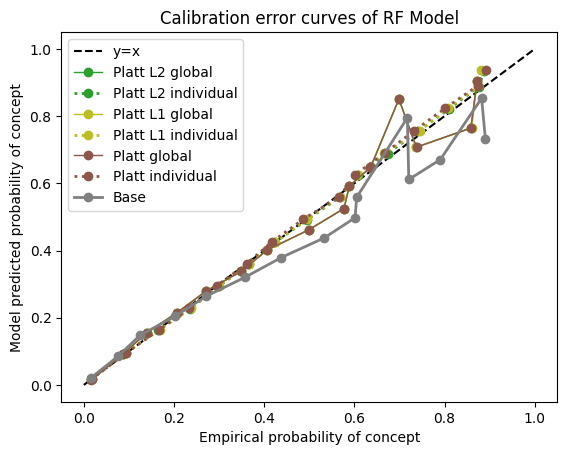

In [55]:
plot_calibration_errors(M1_concepts_cal, test_cosine_similarity_df, test_concepts, 'LCS', 
                        path = 'Results/CBMs/seqCBM-LCS-calibration-error.png')
plot_calibration_errors(M3_concepts_cal, test_embeddings, test_concepts, 'RF', 
                        path = 'Results/CBMs/seqCBM-RF-calibration-error.png')

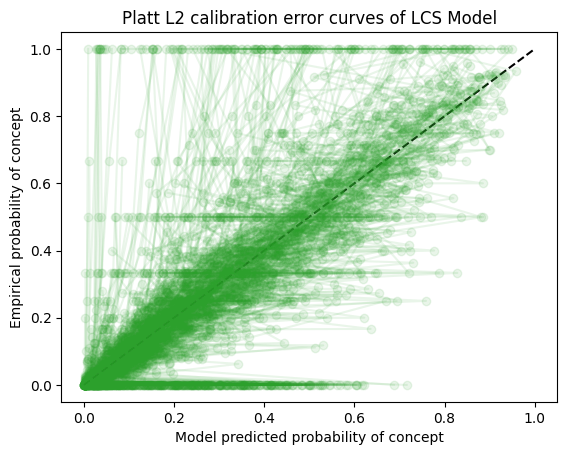

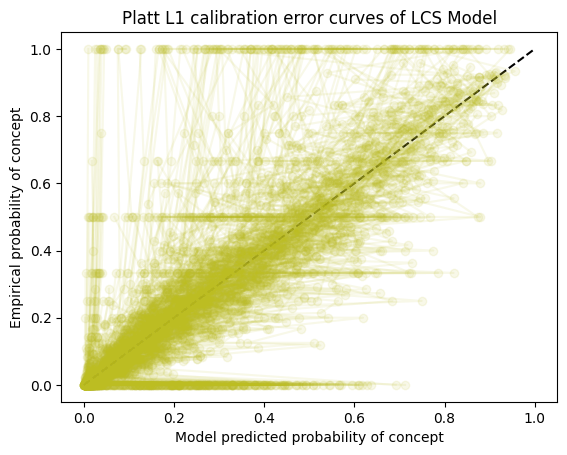

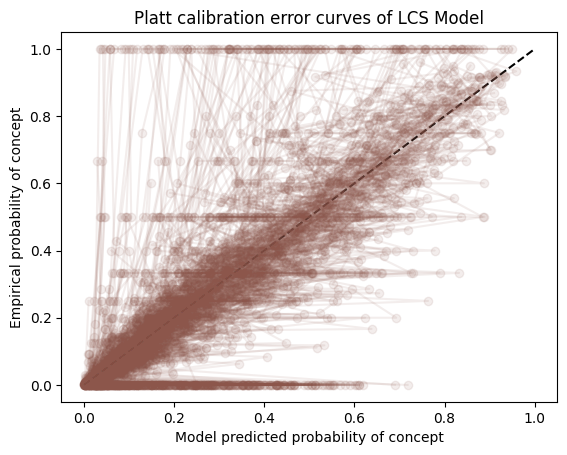

In [56]:
plot_concept_calibration_errors(M1_concepts_cal['Platt L2 individual'], test_cosine_similarity_df, test_concepts, 
                                'LCS', 'Platt L2', path = 'Results/CBMs/seqCBM-LCS-Platt-L2-individual-calibration-errors.png')
plot_concept_calibration_errors(M1_concepts_cal['Platt L1 individual'], test_cosine_similarity_df, test_concepts, 
                                'LCS', 'Platt L1', path = 'Results/CBMs/seqCBM-LCS-Platt-L1-individual-calibration-errors.png')
plot_concept_calibration_errors(M1_concepts_cal['Platt individual'], test_cosine_similarity_df, test_concepts, 
                                'LCS', 'Platt', path = 'Results/CBMs/seqCBM-LCS-Platt-individual-calibration-errors.png')

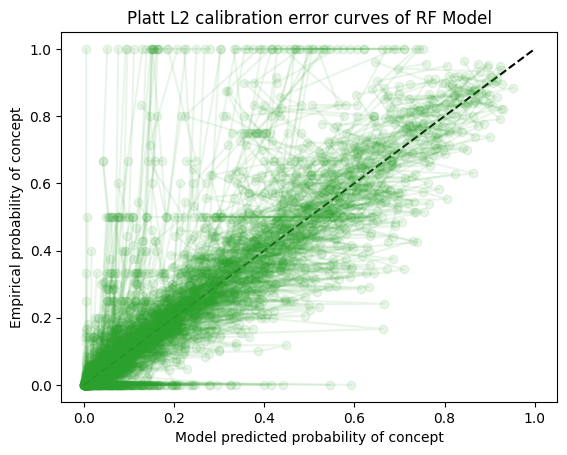

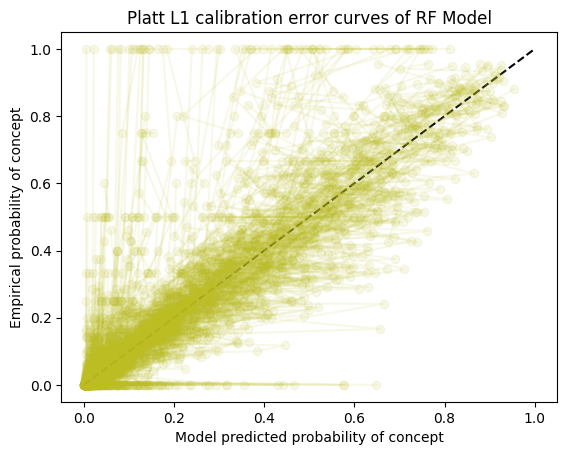

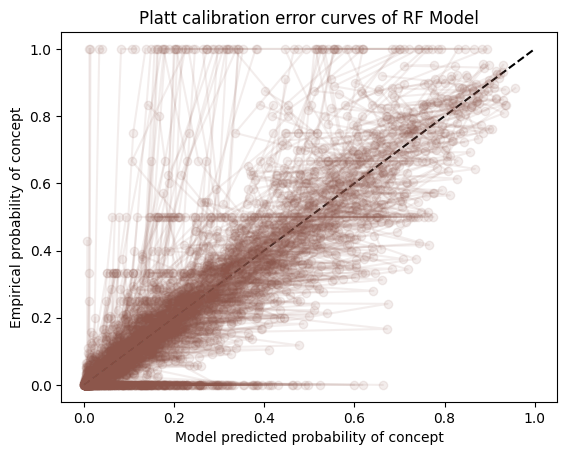

In [795]:
plot_concept_calibration_errors(M3_concepts_cal['Platt L2 individual'], test_embeddings, test_concepts, 
                                'RF', 'Platt L2', path = 'Results/CBMs/seqCBM-RF-Platt-L2-individual-calibration-errors.png')
plot_concept_calibration_errors(M3_concepts_cal['Platt L1 individual'], test_embeddings, test_concepts, 
                                'RF', 'Platt L1', path = 'Results/CBMs/seqCBM-RF-Platt-L1-individual-calibration-errors.png')
plot_concept_calibration_errors(M3_concepts_cal['Platt individual'], test_embeddings, test_concepts, 
                                'RF', 'Platt', path = 'Results/CBMs/seqCBM-RF-Platt-individual-calibration-errors.png')

#### Summarize individual calibrators

In [342]:
# def get_calibrator_params(concept_models):
#     temp_Ts  = np.array([params['T'] for params in concept_models['Temperature individual'].params.values()])
#     platt_As = np.array([params['A'] for params in concept_models['Platt individual'].params.values()])
#     platt_Bs = np.array([params['B'] for params in concept_models['Platt individual'].params.values()])
#     beta_as  = np.array([params['a'] for params in concept_models['Beta individual'].params.values()])
#     beta_bs  = np.array([params['b'] for params in concept_models['Beta individual'].params.values()])
#     beta_cs  = np.array([params['c'] for params in concept_models['Beta individual'].params.values()])

#     params = {'Temperature (T)' : temp_Ts, 
#               'Platt (A)'       : platt_As, 
#               'Platt (B)'       : platt_Bs, 
#               'Beta (a)'        : beta_as, 
#               'Beta (b)'        : beta_bs, 
#               'Beta (c)'        : beta_cs
#              }
#     return params

# def print_calibrator_params(params):
#     for name, arr in params.items():
#         est = np.mean(arr)
#         n = len(arr)
#         ste = ((arr - est)**2).sum()
#         ste = ste**0.5 / (n * (n - 1))**0.5
#         print("{} {} : {:.3f} \u00B1 {:.3f}".format(name, " "*(16 - len(name)), est, ste))

In [343]:
M1_params = get_calibrator_params(M1_concepts_cal)
print_calibrator_params(M1_params)

Temperature (T)   : 0.974 ± 0.003
Platt (A)         : 1.289 ± 0.036
Platt (B)         : 1.225 ± 0.204
Beta (a)          : 1.189 ± 0.041
Beta (b)          : 4.640 ± 1.137
Beta (c)          : 0.744 ± 0.220


In [344]:
M3_params = get_calibrator_params(M3_concepts_cal)
print_calibrator_params(M3_params)

Temperature (T)   : 0.940 ± 0.006
Platt (A)         : 4.114 ± 0.131
Platt (B)         : 9.202 ± 0.572
Beta (a)          : 3.416 ± 0.146
Beta (b)          : 15.761 ± 2.285
Beta (c)          : 6.747 ± 0.635


#### Parameter distributions for per-concept calibration

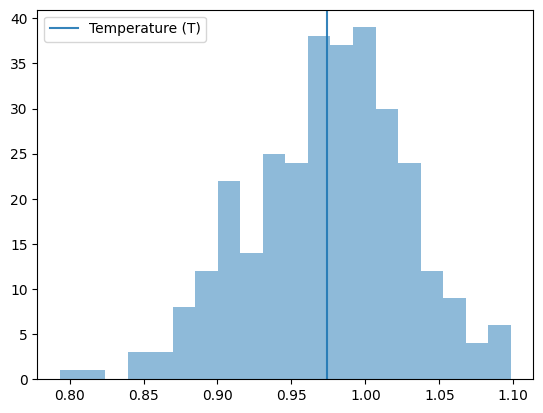

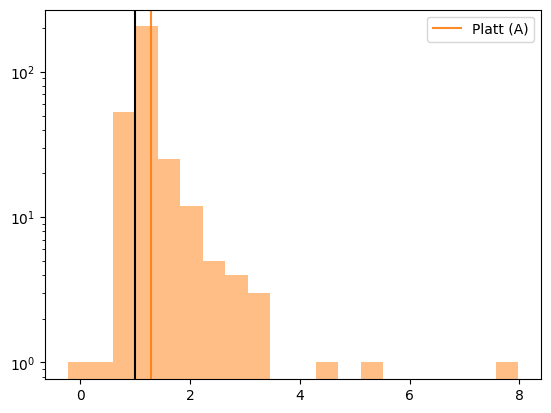

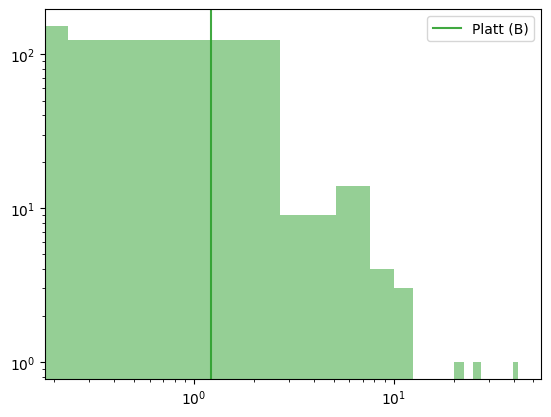

In [346]:
temp_Ts = M1_params['Temperature (T)']
plt.hist(temp_Ts, bins = 20, color = colors[0], alpha = 0.5)
plt.axvline(np.mean(temp_Ts), color = colors[0], label = 'Temperature (T)', alpha = 0.9)
plt.legend()
plt.show()

platt_As = M1_params['Platt (A)']
plt.hist(platt_As, bins = 20, color = colors[1], alpha = 0.5)
plt.axvline(1, color = 'black')
plt.axvline(np.mean(platt_As), color = colors[1], label = 'Platt (A)', alpha = 0.9)
#plt.xlim(-2, 2)
plt.yscale('log')
plt.legend()
plt.show()

platt_Bs = M1_params['Platt (B)']
plt.hist(platt_Bs, bins = 20, color = colors[2], alpha = 0.5)
plt.axvline(0, color = 'black')
plt.axvline(np.mean(platt_Bs), color = colors[2], label = 'Platt (B)', alpha = 0.9)
#plt.xlim(-2, 2)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

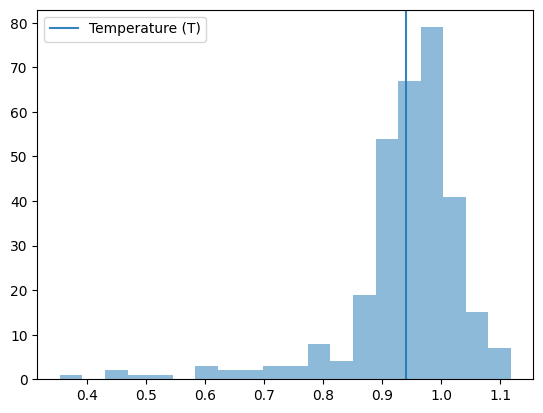

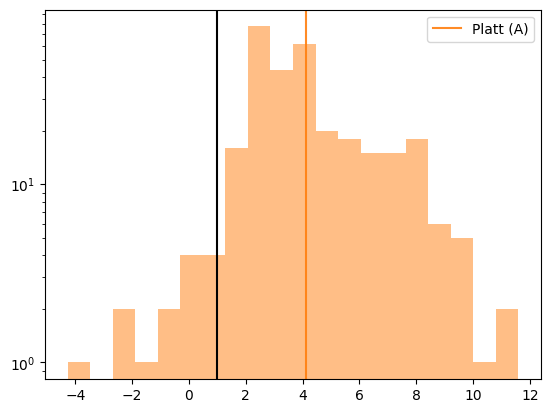

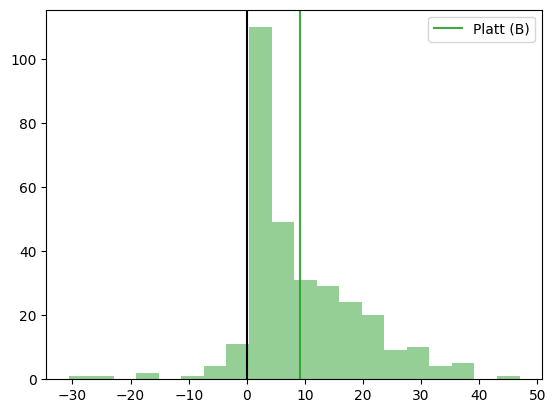

In [348]:
temp_Ts = M3_params['Temperature (T)']
plt.hist(temp_Ts, bins = 20, color = colors[0], alpha = 0.5)
plt.axvline(np.mean(temp_Ts), color = colors[0], label = 'Temperature (T)', alpha = 0.9)
plt.legend()
plt.show()

platt_As = M3_params['Platt (A)']
plt.hist(platt_As, bins = 20, color = colors[1], alpha = 0.5)
plt.axvline(1, color = 'black')
plt.axvline(np.mean(platt_As), color = colors[1], label = 'Platt (A)', alpha = 0.9)
#plt.xlim(-2, 2)
plt.yscale('log')
plt.legend()
plt.show()

platt_Bs = M3_params['Platt (B)']
plt.hist(platt_Bs, bins = 20, color = colors[2], alpha = 0.5)
plt.axvline(0, color = 'black')
plt.axvline(np.mean(platt_Bs), color = colors[2], label = 'Platt (B)', alpha = 0.9)
#plt.xlim(-2, 2)
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()